# SETS

A counterfactual explanation, originally introduced to machine learning by [1], answers the question "what if" by building counterexamples. Based on an input instance $x$, the goal is to find a counterfactual $x^{cf}$ close to the original instance $x$ but differently classified $y \neq y^{cf}$ by a predictor $f$. The intention is to visualize boundary cases. Further research has shown that counterfactual explanations are easy to understand for humans because they are intuitive  to human thinking by showing counterexamples.  

Shapelet-based Temporal Association Rule Mining for Multivariate Time Series Classification developed by Bahri et al. [1] builds counterfactuals in multivariate setting by perturbing the features of a time series with the help of a shapelet algorithm. Hereby they extract the most prominent class shapelets using an adaption of the shapelet transform algorithm of [2] implemented in sktime. The algorithm is adapted to multivariate timeseries analysis, treating each dimension as a univariate timeseries and information gain. The algorithm imputes the shapelets based on prior observed occcurences and shapelet quality. If a single shapelet does not cause a counterfactual prediction, more perturbations in other dimensions or other parts of the timeseries are performed. 


<img src="https://fzi-forschungszentrum-informatik.github.io/TSInterpret/Notebooks/SETS_CF.png" alt="Visualization of SETS_CF" style="width: 800px;" />



Visualization of SETS from the original paper [1]; The code in TSInterpret is based on the authors <a href='https://github.com/omarbahri/SETS'>implementation </a>.

[1] Omar Bahri and Soukaina Filali Boubrahimi and Shah Muhammad Hamdi.Shapelet-Based Counterfactual Explanations for Multivariate Time Series. 2022 ACM SIGKDD Workshop on Mining and Learning from Time Series. arXiv:2208.10462 URL:https://arxiv.org/abs/2208.10462 (visited on 2023-12-04)


[2] Hills, Jon and Lines, Jason and Baranauskas, Edgaras and Mapp, James and Bagnall, Anthony. Classification of time series by shapelet transformation. Data Mining and Knowledge Discovery. Harv. JL & Tech. 31 (2017): 841.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import numpy as np
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
from sklearn import tree
from sklearn.model_selection import cross_val_score
from pymop import Problem
import os
from tslearn.datasets import UCR_UEA_datasets
import warnings
warnings.filterwarnings('ignore')
import pickle
import sklearn

### Multivariate Case

In [2]:
import sklearn
dataset='BasicMotions'
X_train,train_y,X_test,test_y=UCR_UEA_datasets().load_dataset(dataset)
#train_x=np.swapaxes(X_train,1,2)
#test_x=np.swapaxes(X_test,1,2)
train_x=X_train
test_x=X_test
#enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(train_y.reshape(-1, 1))#pickle.load(open(f'../../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','rb'))
#test_y=enc1.transform(test_y.reshape(-1,1))
#train_y=enc1.transform(train_y.reshape(-1,1))
n_classes = len(np.unique(test_y))


In [3]:
from ClassificationModels.CNN_T import ResNetBaseline, UCRDataset, get_all_preds
from ClassificationModels.LSTM_T import LSTM

device = torch.device( "cpu")#"cuda:0" if torch.cuda.is_available() else
#model = ResNetBaseline(in_channels=train_x.shape[1], num_pred_classes=n_classes)
device='cpu'
hidden_size=10
rnn=0.1
model = LSTM(6, hidden_size ,n_classes,rnndropout=rnn).to(device)
#fit(model,train_loader,test_loader)
model.load_state_dict(torch.load(f'../../ClassificationModels//models/{dataset}/LSTM'))
test_dataset = UCRDataset(test_x,test_y)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=True)

In [4]:
model.eval()


LSTM(
  (drop): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=10, out_features=4, bias=True)
  (rnn): LSTM(6, 10, batch_first=True)
)

In [5]:
y_pred=model(torch.from_numpy(train_x).float()).detach().numpy()


In [6]:
%load_ext autoreload
%autoreload 2

from TSInterpret.InterpretabilityModels.counterfactual.SETSCF import SETSCF
exp_model= SETSCF(model,
                  (train_x,train_y),
                  backend='PYT',
                  mode='time',         
                  min_shapelet_len=3,
                  max_shapelet_len=20,
                  time_contract_in_mins_per_dim=1,
                  #initial_num_shapelets_per_case=10,
                  fit_shapelets = False,
                  le=False)

Extract Shapelets with information gain rejection lvl 0.001 and shapelets per class of 30


In [7]:
exp_model.fit(occlusion_threshhold=1e-1,remove_multiclass_shapelets=True)

Fit function to prune shapelets with occlusion threshhold of 0.1 and remove shapelets belonging to more than one class set to True
Shapelet by index per class and dimension: {0: [[0, 1, 21, 22, 26, 27, 28, 31, 32, 33, 34, 35, 36, 39, 40, 41, 45, 46, 47, 49, 64, 69, 71], [0, 1, 2, 3, 4, 33, 35, 36, 38, 39, 42, 43, 48, 50, 52, 57, 58, 65, 71, 72], [0, 6, 9, 10, 17, 18, 20, 22, 25, 26, 34, 37, 40, 43, 48, 50, 61, 62, 66], [15, 16, 24, 28, 29, 30, 31, 32, 36, 39, 40, 42, 44, 51, 53, 59, 66, 69, 70, 71, 73], [3, 8, 10, 15, 16, 22, 27, 28, 29, 30, 31, 36, 43, 46, 55, 56, 57, 58, 60, 61, 66, 67, 75], [0, 1, 2, 3, 4, 5, 6, 7, 24, 25, 26, 33, 36, 37, 38, 39, 45, 48, 49, 52, 59, 65]], 1: [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 29, 57, 62], [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 37, 60], [14, 23, 27, 28, 29, 32, 35, 44, 47, 49, 51, 52, 53, 54, 56, 63, 64, 67, 68, 69], [0, 2, 3, 4, 7, 8, 10, 12, 19, 20, 23, 25, 34, 37, 43, 57], [0, 4, 5, 11, 12, 13, 14, 17, 20, 23, 32, 3

In [8]:
ts = 1
cf_explanation, label = exp_model.explain(train_x[ts], target =0)

Counterfactual has been found


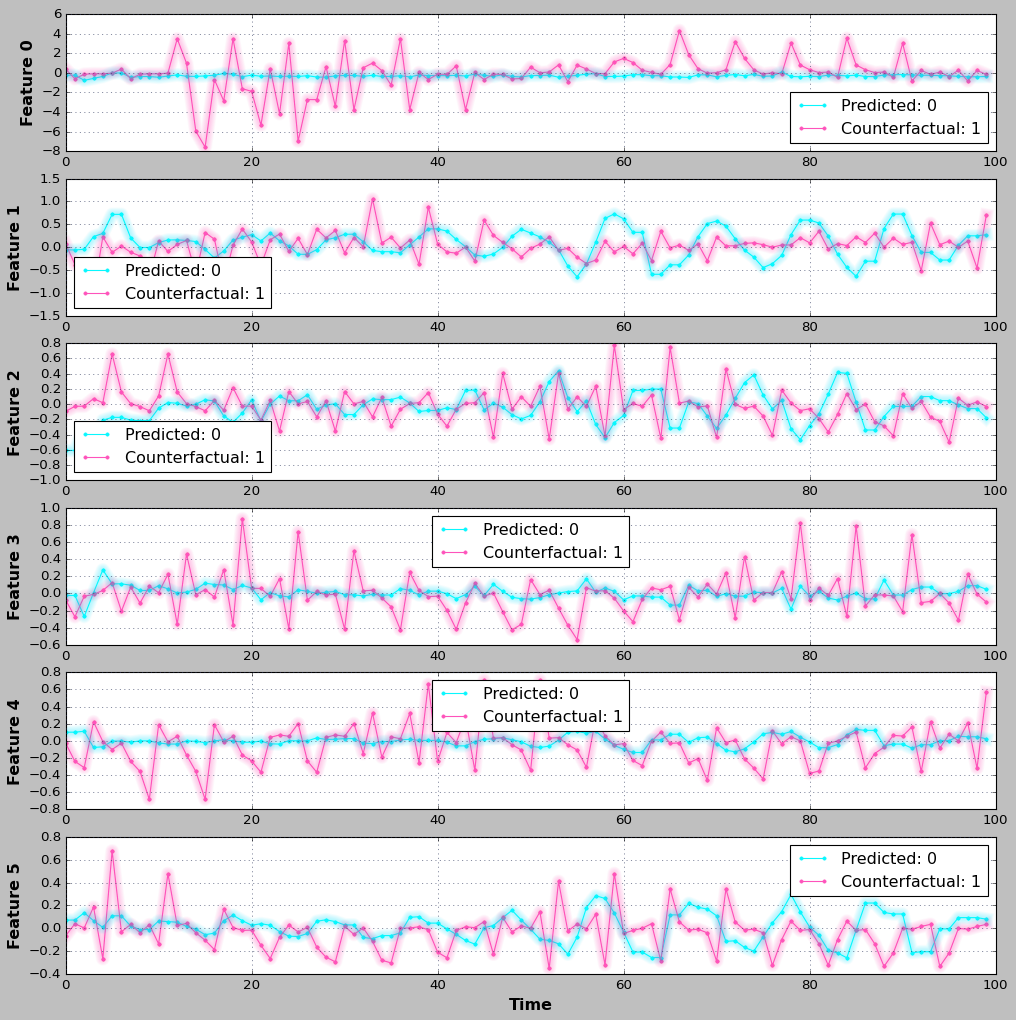

In [9]:
#item, org_label, exp, cf_label, save_fig=None, figsize=(6.4, 4.8)
exp_model.plot_in_one(test_x[ts],0,cf_explanation,1,figsize=(15,15))